In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# ---------------------- Dataset Class ----------------------

In [2]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# ---------------------- Paths & Setup ----------------------

In [3]:
# folder paths
image_dir = r"/home/user/dsr_project/dataset/Co-registered/Simulated dataset/images/RGB"
mask_dir = r"/home/user/dsr_project/dataset/Co-registered/Simulated dataset/saliency_masks"

# Match image and mask files
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".jpg") or f.endswith(".png")])

# Split 
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = SaliencyDataset(train_imgs, train_masks, transform=transform)
test_dataset = SaliencyDataset(test_imgs, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---------------------- Defined Model ----------------------

In [4]:
class SimpleSaliencyNet(nn.Module):
    def __init__(self):
        super(SimpleSaliencyNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ---------------------- Training Setup ----------------------

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSaliencyNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Loop ----------------------

In [6]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/100], Loss: 0.1551
Epoch [2/100], Loss: 0.1160
Epoch [3/100], Loss: 0.0991
Epoch [4/100], Loss: 0.0902
Epoch [5/100], Loss: 0.0834
Epoch [6/100], Loss: 0.0733
Epoch [7/100], Loss: 0.0682
Epoch [8/100], Loss: 0.0648
Epoch [9/100], Loss: 0.0582
Epoch [10/100], Loss: 0.0533
Epoch [11/100], Loss: 0.0507
Epoch [12/100], Loss: 0.0483
Epoch [13/100], Loss: 0.0488
Epoch [14/100], Loss: 0.0452
Epoch [15/100], Loss: 0.0444
Epoch [16/100], Loss: 0.0409
Epoch [17/100], Loss: 0.0409
Epoch [18/100], Loss: 0.0399
Epoch [19/100], Loss: 0.0377
Epoch [20/100], Loss: 0.0368
Epoch [21/100], Loss: 0.0347
Epoch [22/100], Loss: 0.0334
Epoch [23/100], Loss: 0.0324
Epoch [24/100], Loss: 0.0325
Epoch [25/100], Loss: 0.0295
Epoch [26/100], Loss: 0.0309
Epoch [27/100], Loss: 0.0298
Epoch [28/100], Loss: 0.0301
Epoch [29/100], Loss: 0.0276
Epoch [30/100], Loss: 0.0274
Epoch [31/100], Loss: 0.0264
Epoch [32/100], Loss: 0.0255
Epoch [33/100], Loss: 0.0246
Epoch [34/100], Loss: 0.0259
Epoch [35/100], Loss: 0

# ---------------------- Visualization ----------------------

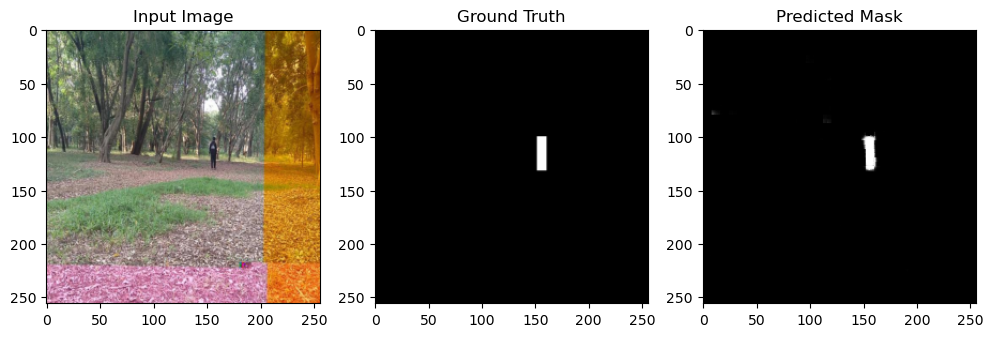

In [7]:
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Visualize first sample
        output_np = outputs[0][0].cpu().numpy()
        mask_np = masks[0][0].cpu().numpy()
        image_np = images[0].permute(1, 2, 0).cpu().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(image_np)
        ax[0].set_title("Input Image")
        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title("Ground Truth")
        ax[2].imshow(output_np, cmap='gray')
        ax[2].set_title("Predicted Mask")
        plt.show()
        break

# ---------------------- Saving the model -------------------

In [8]:
# Save trained model weights
torch.save(model.state_dict(), "/home/user/dsr_project/experiments/saliency_model.pth")
print("Model saved as saliency_model.pth")

Model saved as saliency_model.pth


In [9]:
# Instantiate model and load weights
model = SimpleSaliencyNet().to(device)
model.load_state_dict(torch.load("saliency_model.pth"))
model.eval()

/tmp/ipykernel_2314053/3653021037.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saliency_model.pth"))


SimpleSaliencyNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

# ------------ Metrics and application example ------------

In [10]:
def compute_iou(pred_mask, true_mask, threshold=0.5):
    pred_bin = (pred_mask > threshold).astype(np.uint8)
    true_bin = (true_mask > 0.5).astype(np.uint8)

    intersection = np.logical_and(pred_bin, true_bin).sum()
    union = np.logical_or(pred_bin, true_bin).sum()

    if union == 0:  # Avoid division by zero
        return float(intersection == 0)
    return intersection / union

ious = []

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(images.size(0)):
            pred = outputs[i][0].cpu().numpy()
            true = masks[i][0].cpu().numpy()
            iou = compute_iou(pred, true)
            ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU on test set: {mean_iou:.4f}")

Mean IoU on test set: 0.7393


In [11]:
def is_object_present(saliency_map, threshold=0.5, pixel_fraction=0.01):
    binary_mask = saliency_map > threshold
    active_pixels = np.sum(binary_mask)
    total_pixels = binary_mask.size
    return active_pixels / total_pixels > pixel_fraction

In [12]:
# Object detection recall based on saliency
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(images.size(0)):
            pred = outputs[i][0].cpu().numpy()
            true = masks[i][0].cpu().numpy()

            # GT: is there any object in the mask?
            object_in_gt = is_object_present(true, threshold=0.5, pixel_fraction=0.01)
            object_in_pred = is_object_present(pred, threshold=0.5, pixel_fraction=0.01)

            y_true.append(object_in_gt)
            y_pred.append(object_in_pred)

# Compute Recall
true_positive = sum([t and p for t, p in zip(y_true, y_pred)])
false_negative = sum([t and not p for t, p in zip(y_true, y_pred)])
recall = true_positive / (true_positive + false_negative + 1e-6)  # avoid division by zero
print(f"Object Presence Recall: {recall:.4f}")


Object Presence Recall: 0.9875


Predicted: Object Present
Ground Truth: Object Present


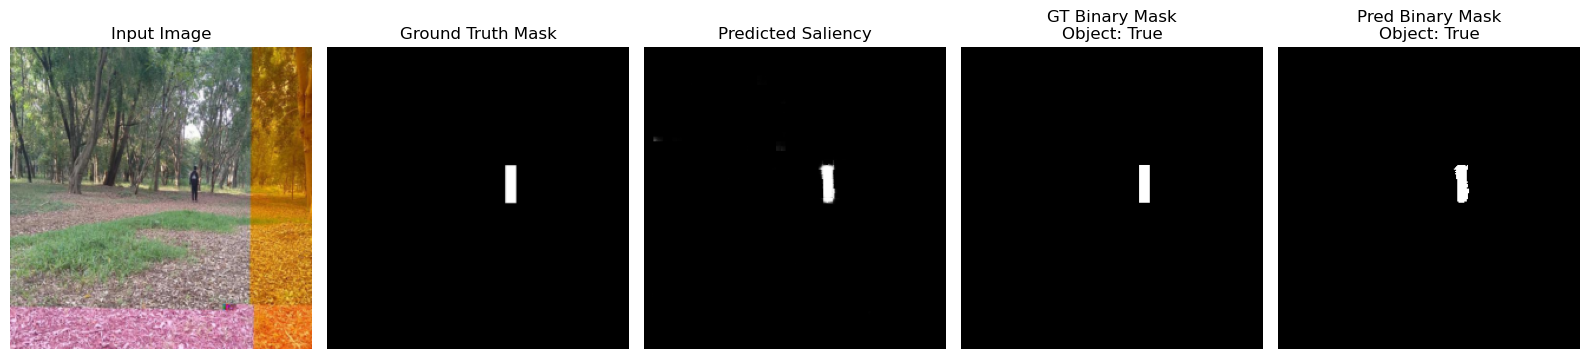

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_detection_logic(model, dataloader, threshold=0.5, area_fraction=0.001):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            pred = outputs[0][0].cpu().numpy()  # Predicted saliency
            gt = masks[0][0].cpu().numpy()      # Ground truth saliency
            image = images[0].permute(1, 2, 0).cpu().numpy()

            # Thresholding
            pred_bin = pred > threshold
            gt_bin = gt > threshold

            # Object presence based on saliency area
            pred_present = (np.sum(pred_bin) / pred_bin.size) > area_fraction
            gt_present = (np.sum(gt_bin) / gt_bin.size) > area_fraction

            print(f"Predicted: {'Object Present' if pred_present else 'No Object'}")
            print(f"Ground Truth: {'Object Present' if gt_present else 'No Object'}")

            # Visualization
            fig, axs = plt.subplots(1, 5, figsize=(16, 4))
            axs[0].imshow(image)
            axs[0].set_title("Input Image")
            axs[1].imshow(gt, cmap="gray")
            axs[1].set_title("Ground Truth Mask")
            axs[2].imshow(pred, cmap="gray")
            axs[2].set_title("Predicted Saliency")
            axs[3].imshow(gt_bin, cmap="gray")
            axs[3].set_title(f"GT Binary Mask\nObject: {gt_present}")
            axs[4].imshow(pred_bin, cmap="gray")
            axs[4].set_title(f"Pred Binary Mask\nObject: {pred_present}")

            for ax in axs:
                ax.axis('off')
            plt.tight_layout()
            plt.show()
            break  # Show one sample only

# Example usage
visualize_detection_logic(model, test_loader, threshold=0.5, area_fraction=0.0005)

# Alternate Method

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [3]:
class SimpleSaliencyNet(nn.Module):
    def __init__(self):
        super(SimpleSaliencyNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSaliencyNet().to(device)
model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/experiments/saliency_model.pth", map_location=device))
model.eval()

/tmp/ipykernel_2369623/3879981367.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/experiments/saliency_mo

SimpleSaliencyNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [5]:
test_image_dir = r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/RGB"
test_mask_dir = r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/saliency_masks"

image_files = sorted([os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith(('.jpg', '.png'))])
mask_files = sorted([os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir) if f.endswith(('.jpg', '.png'))])

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

test_dataset = SaliencyDataset(image_files, mask_files, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [6]:
def compute_min_salient_fraction(dataloader):
    min_fraction = float('inf')
    for _, masks in dataloader:
        for mask in masks:
            mask_np = mask[0].numpy()
            binary_mask = (mask_np > 0.5).astype(np.uint8)
            frac = np.sum(binary_mask) / binary_mask.size
            min_fraction = min(min_fraction, frac)
    return min_fraction

threshold_fraction = compute_min_salient_fraction(test_loader)
print(f"Data-driven Saliency Threshold (from GT): {threshold_fraction:.4f}")

Data-driven Saliency Threshold (from GT): 0.0000


In [9]:
def compute_min_salient_fraction(dataloader):
    min_fraction = float('inf')
    valid_count = 0

    for _, masks in dataloader:
        for mask in masks:
            mask_np = mask[0].numpy()
            binary_mask = (mask_np > 0.5).astype(np.uint8)
            total_pixels = binary_mask.size
            salient_pixels = np.sum(binary_mask)

            if salient_pixels == 0:
                continue  # Skip completely black masks

            frac = salient_pixels / total_pixels
            min_fraction = min(min_fraction, frac)
            valid_count += 1

    if valid_count == 0:
        raise ValueError("No non-empty masks found in dataset.")

    return min_fraction

threshold_fraction = compute_min_salient_fraction(test_loader)
print(f"Data-driven Saliency Threshold (non-empty GT): {threshold_fraction:.4f}")

Data-driven Saliency Threshold (non-empty GT): 0.0009


In [10]:
y_true, y_pred = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        pred = outputs[0][0].cpu().numpy()
        true = masks[0][0].cpu().numpy()

        pred_bin = (pred > 0.5).astype(np.uint8)
        true_bin = (true > 0.5).astype(np.uint8)

        pred_fraction = np.sum(pred_bin) / pred_bin.size
        true_fraction = np.sum(true_bin) / true_bin.size

        object_pred = pred_fraction > threshold_fraction
        object_true = true_fraction > threshold_fraction

        y_true.append(object_true)
        y_pred.append(object_pred)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Precision: 0.9968
Recall:    1.0000
F1-score:  0.9984


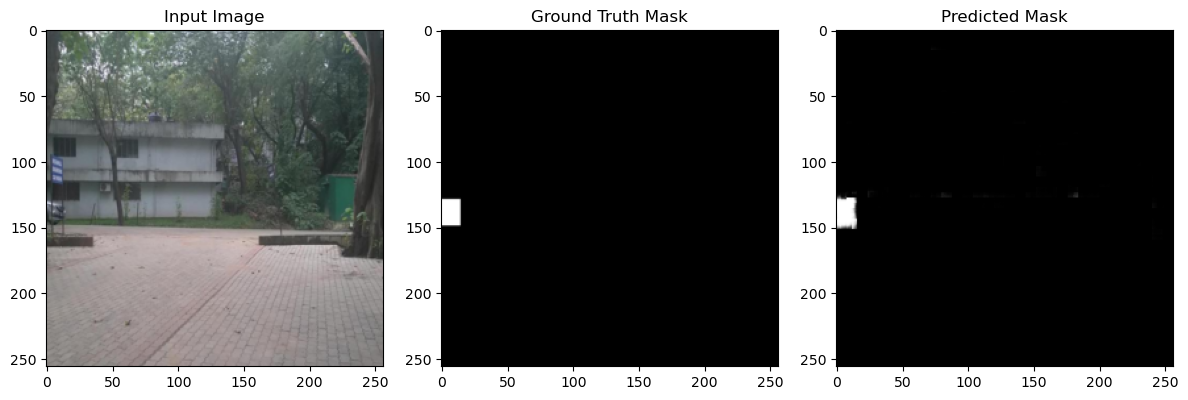

In [11]:
# Just to visualize one prediction
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        image = images[0].permute(1, 2, 0).cpu().numpy()
        true_mask = masks[0][0].cpu().numpy()
        pred_mask = outputs[0][0].cpu().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(image)
        ax[0].set_title("Input Image")

        ax[1].imshow(true_mask, cmap="gray")
        ax[1].set_title("Ground Truth Mask")

        ax[2].imshow(pred_mask, cmap="gray")
        ax[2].set_title("Predicted Mask")

        plt.tight_layout()
        plt.show()
        break